In [9]:
%matplotlib inline
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import re


In [2]:


def load_summary_results(save_root):
    save_root = Path(save_root)
    session_folders = [f for f in save_root.iterdir() if f.is_dir()]
    
    summary_data = []

    for folder in session_folders:
        json_file = folder / "tongue_quality_stats.json"
        if not json_file.exists():
            continue
        
        with open(json_file, "r") as f:
            results = json.load(f)
        
        # Flatten percentiles into columns
        row = {
            "session_id": results["session_id"],
            "coverage_pct": results["coverage_pct"],
        }
        for metric, pct_dict in results["percentiles"].items():
            for pct, val in pct_dict.items():
                row[f"{metric}_{pct}"] = val

        summary_data.append(row)
    
    return pd.DataFrame(summary_data)





In [3]:

def plot_combined_summary(summary_df):
    # Sort by coverage for barplot
    summary_df_sorted = summary_df.sort_values("coverage_pct")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df_sorted["session_id"], summary_df_sorted["coverage_pct"], color="skyblue")
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df["coverage_pct"], summary_df["dropped_frames_n_0.9"], 
                    color="red", s=70, alpha=0.7, edgecolor='k')
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Dropped Frames (90th %ile)")
    axes[1].set_title("Dropped Frames vs Coverage")
    axes[1].grid(True, alpha=0.3)

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df["coverage_pct"], summary_df["duration_0.5"], 
                    color="green", s=70, alpha=0.7, edgecolor='k')
    axes[2].set_xlabel("Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Coverage")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [4]:
# Example usage
save_root = "/root/capsule/scratch/session_analysis_out_of_distribution_full"
summary_df = load_summary_results(save_root)
summary_df_ood = summary_df[summary_df["session_id"] != "behavior_751004_2024-12-23_14-19-57"]

# Example usage
save_root2 = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root2)


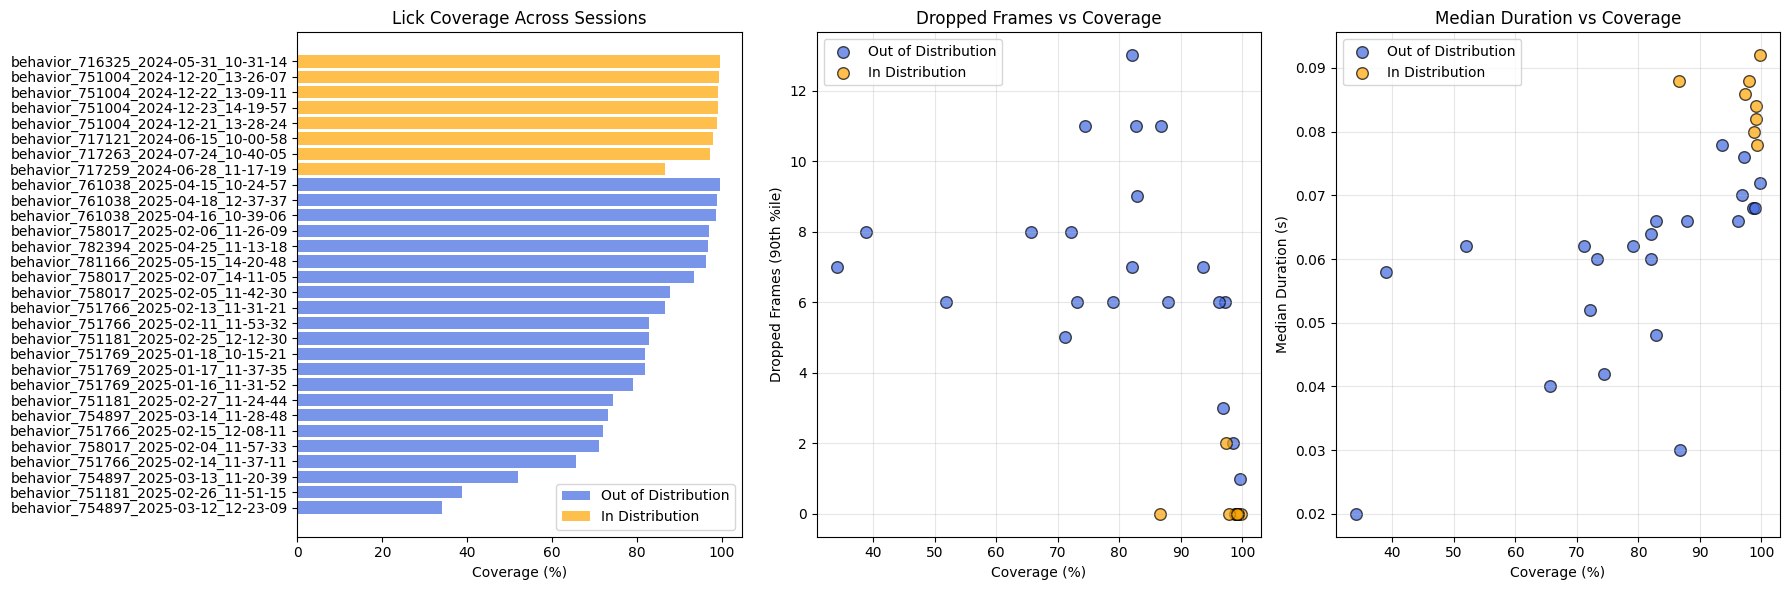

In [5]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Sort by coverage for barplot
    summary_df1_sorted = summary_df1.sort_values("coverage_pct")
    summary_df2_sorted = summary_df2.sort_values("coverage_pct")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Dropped Frames (90th %ile)")
    axes[1].set_title("Dropped Frames vs Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [6]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Combine session_id and coverage_pct from both, drop duplicates, sort by coverage
    combined = pd.concat([
        summary_df1[["session_id", "coverage_pct"]],
        summary_df2[["session_id", "coverage_pct"]]
    ]).drop_duplicates().sort_values("coverage_pct")
    session_order = combined["session_id"].tolist()

    # Reindex both dfs to this order (sessions not present will be dropped)
    summary_df1_sorted = summary_df1.set_index("session_id").reindex(session_order).reset_index()
    summary_df2_sorted = summary_df2.set_index("session_id").reindex(session_order).reset_index()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Lick Coverage (%)")
    axes[1].set_ylabel("90th %ile Dropped Frames (number)")
    axes[1].set_title("Dropped Frames vs Lick Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Lick Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Lick Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

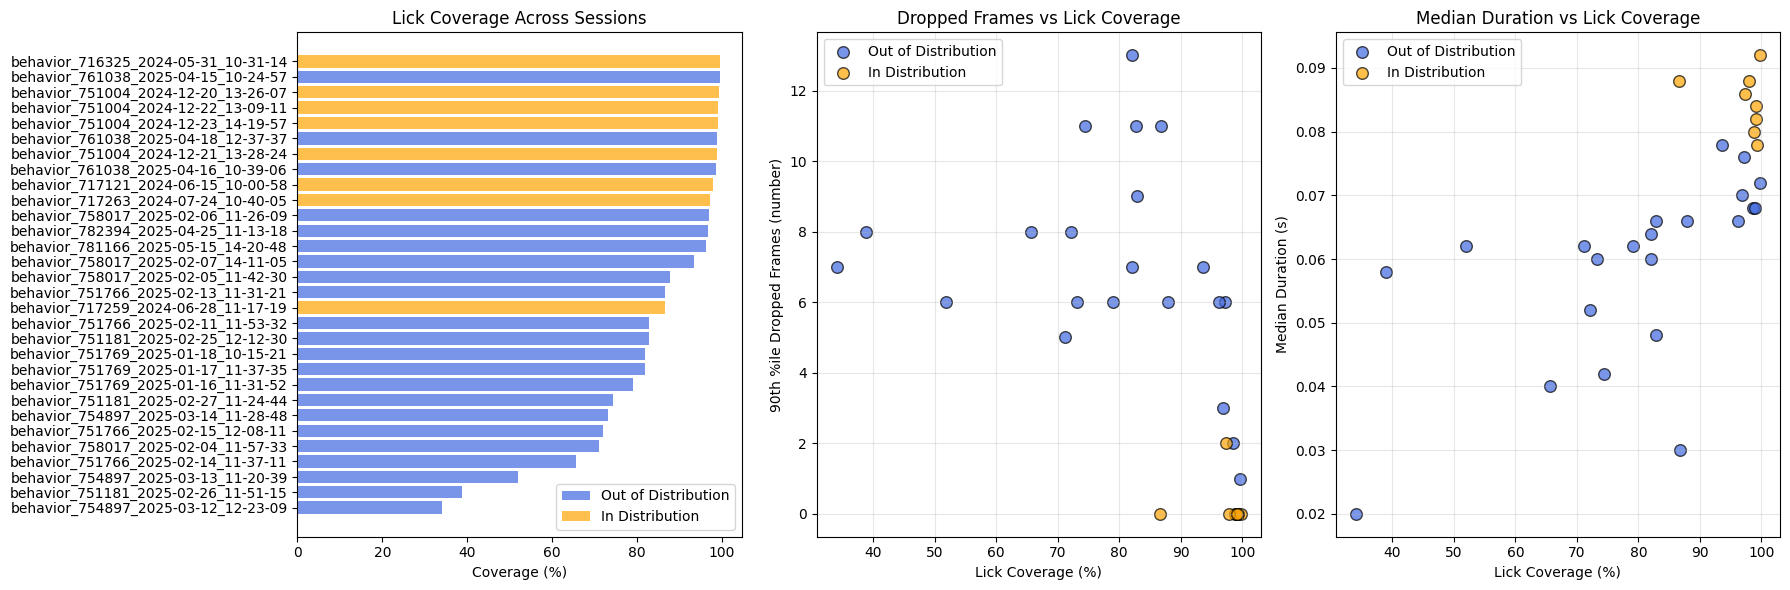

In [7]:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [13]:
# Check session consistency between pred_csv_list.json and saved session folders
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path

# Load the list of session paths from pred_csv_list.json
with open("/root/capsule/scratch/pred_csv_list.json", "r") as f:
    pred_csv_list = json.load(f)

# Extract session_id from each path using get_session_name_from_path
session_order_full = [get_session_name_from_path(str(p)) for p in pred_csv_list]
session_ids_all = set(session_order_full)

# Get session folder names in save_root
save_root = "/root/capsule/scratch/session_analysis_out_of_distribution_full"
session_folders = [f.name for f in Path(save_root).iterdir() if f.is_dir()]
session_ids_in_folder = set(session_folders)

# Compare session_ids from pred_csv_list.json to session folders in save_root
missing_in_folder = session_ids_all - session_ids_in_folder
extra_in_folder = session_ids_in_folder - session_ids_all

print("Session IDs in pred_csv_list.json but missing in save_root folder:", missing_in_folder)
print("Session folders in save_root but not in pred_csv_list.json:", extra_in_folder)

Session IDs in pred_csv_list.json but missing in save_root folder: set()
Session folders in save_root but not in pred_csv_list.json: set()


In [16]:
paths = [p for p in Path("/root/capsule/data").iterdir() if p.is_dir() and "videoprocessed" in p.name]
# for p in paths:
#     print(p)

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path

def _parse_stats(fp: Path):
    out = {}
    for line in open(fp, "r"):
        if ":" not in line: 
            continue
        k, v = [s.strip() for s in line.split(":", 1)]
        if k.startswith("Number of sampled frames"): out["n_sampled_frames"] = int(float(v))
        elif k == "Mean Contrast":                  out["mean_contrast"] = float(v)
        elif k == "Mean SNR":                       out["mean_snr"] = float(v)
        elif k == "Mean Laplacian Variance":        out["mean_laplacian_variance"] = float(v)
    return out

rows = []
for folder in paths:
    folder = Path(folder)
    stats_files = list((folder / "previews").glob("*.mp4_stats.txt")) + list(folder.glob("*.mp4_stats.txt"))
    for f in stats_files:
        rows.append({
            "session": get_session_name_from_path(str(folder)),
            "camera": re.sub(r"(?:_camera)?\.mp4_stats\.txt$", "", f.name),
            "stats_path": str(f),
            **_parse_stats(f),
        })

df_video_stats = pd.DataFrame(rows)




In [20]:
# --- Check uniqueness of session entries ---
dup_sessions = df_video_stats['session'].value_counts()
dup_sessions = dup_sessions[dup_sessions > 1]

if len(dup_sessions) > 0:
    print("⚠️ Warning: multiple video stats entries found for these sessions:")
    print(dup_sessions)
    # optionally, raise an error instead of just printing:
    # raise ValueError(f"Non-unique sessions found: {list(dup_sessions.index)}")
else:
    print("✅ All sessions unique in df_video_stats")

# --- If unique, rename and merge directly ---
video_summary = df_video_stats.rename(columns={"session": "session_id"})

summary_df_ood_merged = summary_df_ood.merge(video_summary, on="session_id", how="left")
summary_df_id_merged  = summary_df_id.merge(video_summary,  on="session_id", how="left")

✅ All sessions unique in df_video_stats


In [21]:


def plot_video_metrics_compare(summary_df1, summary_df2, x_var="coverage_pct",
                               label1="Out of Distribution", label2="In Distribution"):
    """
    Compare video quality metrics vs a chosen x_var for two summary DataFrames.

    x_var options:
        - "coverage_pct"
        - "duration_0.5"          (median duration)
        - "dropped_frames_n_0.9"  (90th percentile dropped frames)

    Expects columns in the DataFrames:
        x_var, mean_contrast, mean_snr, mean_laplacian_variance
    """
    # Keep only needed cols and drop rows missing either x or any metric
    needed = [x_var, "mean_contrast", "mean_snr", "mean_laplacian_variance"]
    df1 = summary_df1[["session_id"] + needed].dropna(subset=needed).copy()
    df2 = summary_df2[["session_id"] + needed].dropna(subset=needed).copy()

    # Sort by x for a consistent visual order (optional)
    df1 = df1.sort_values(x_var)
    df2 = df2.sort_values(x_var)

    metrics = [
        ("mean_contrast", "Mean Contrast"),
        ("mean_snr", "Mean SNR"),
        ("mean_laplacian_variance", "Mean Laplacian Variance"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)
    for ax, (col, title) in zip(axes, metrics):
        ax.scatter(df1[x_var], df1[col], s=70, alpha=0.7, edgecolor="k", label=label1)
        ax.scatter(df2[x_var], df2[col], s=70, alpha=0.7, edgecolor="k", label=label2)

        # Labels/titles
        ax.set_xlabel({
            "coverage_pct": "Lick Coverage (%)",
            "duration_0.5": "Median Duration (s)",
            "dropped_frames_n_0.9": "90th %ile Dropped Frames (number)"
        }.get(x_var, x_var))
        ax.set_ylabel(title)
        ax.set_title(f"{title} vs {ax.get_xlabel()}")
        ax.grid(True, alpha=0.3)

    # Legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(handles, labels, loc="best")

    plt.tight_layout()
    plt.show()


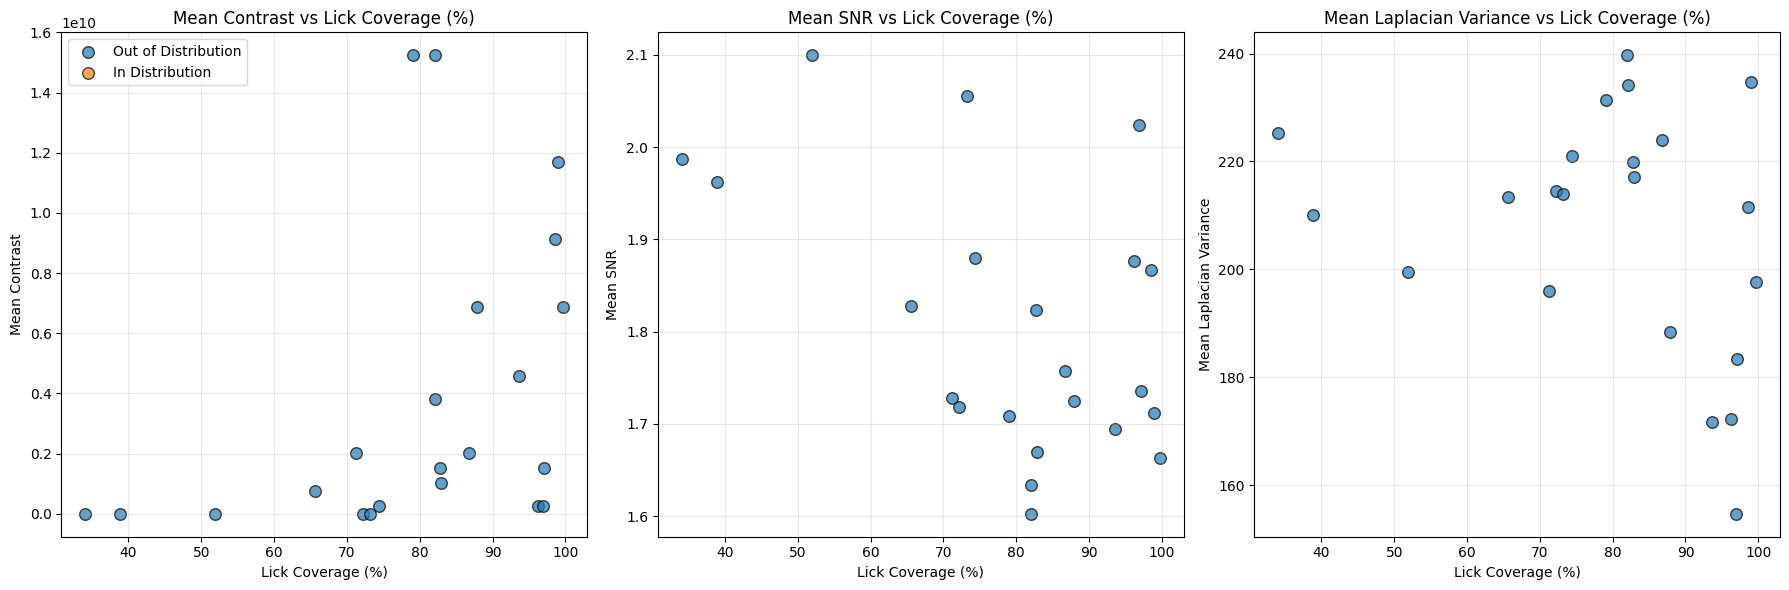

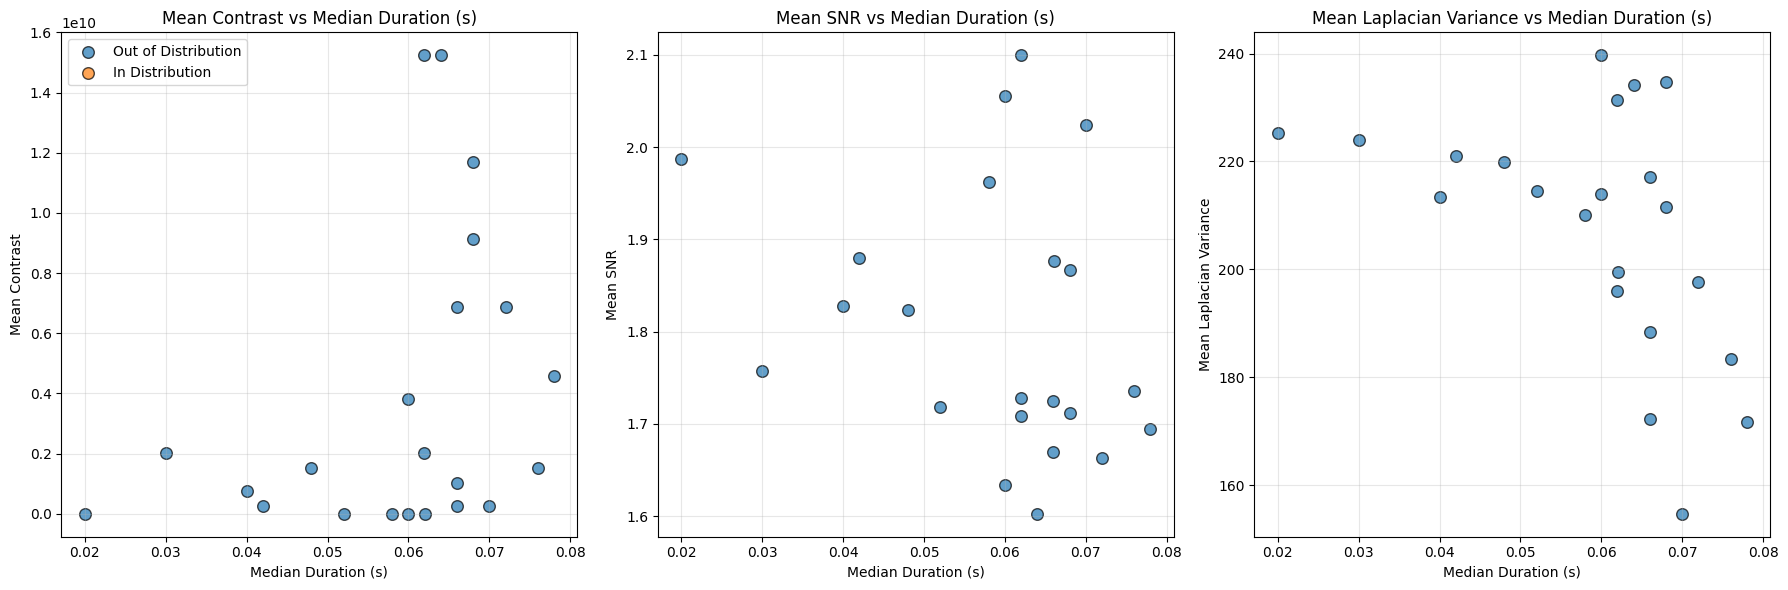

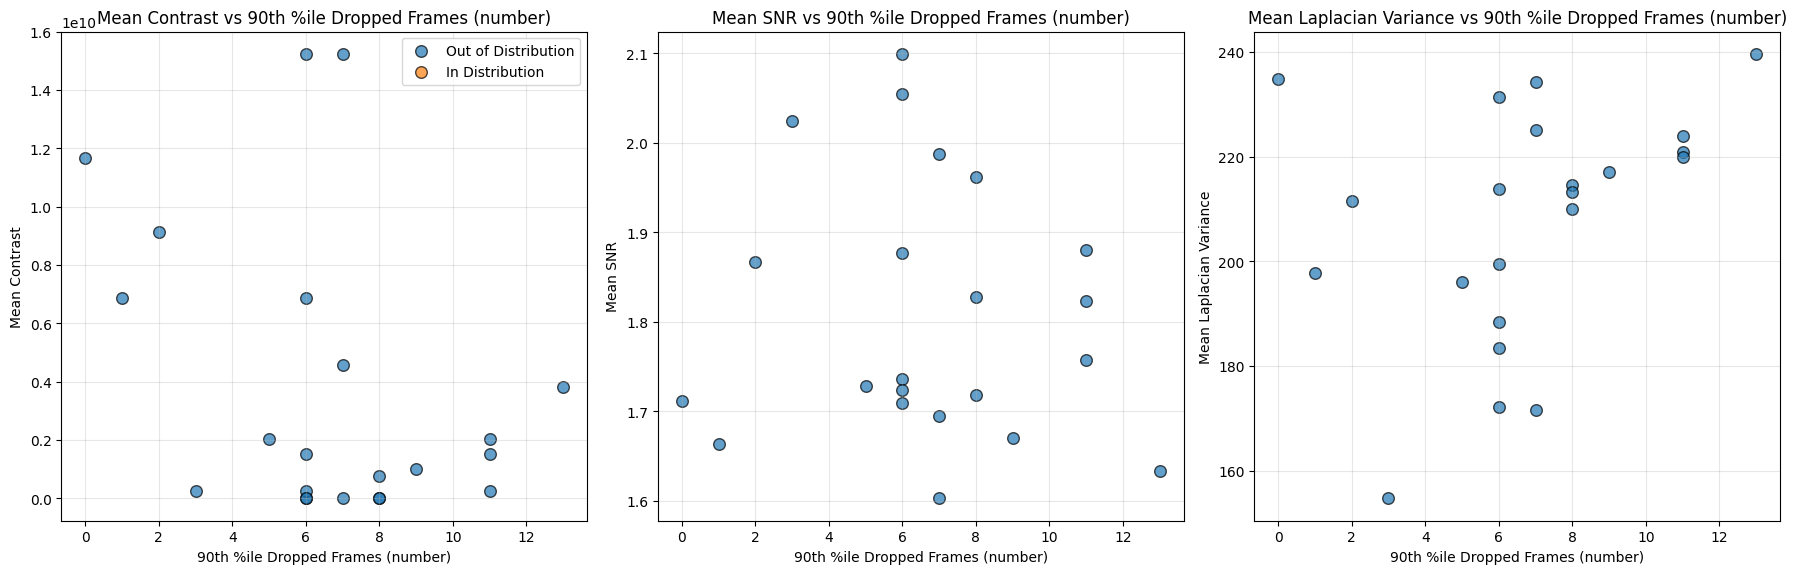

In [22]:
# After you’ve merged video stats:
# summary_df_ood_merged, summary_df_id_merged

plot_video_metrics_compare(summary_df_ood_merged, summary_df_id_merged, x_var="coverage_pct")
plot_video_metrics_compare(summary_df_ood_merged, summary_df_id_merged, x_var="duration_0.5")
plot_video_metrics_compare(summary_df_ood_merged, summary_df_id_merged, x_var="dropped_frames_n_0.9")


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Label sessions with good (>80%) lick coverage
labeled = pd.concat([summary_df_ood_merged, summary_df_id_merged], ignore_index=True)
labeled = labeled.dropna(subset=["mean_contrast", "mean_snr", "mean_laplacian_variance", "coverage_pct"]).copy()
labeled["good_lick_coverage"] = (
    (labeled["coverage_pct"] > 80) &
    (labeled["duration_0.5"] > 0.06)
).astype(int)

X = labeled[["mean_contrast", "mean_snr", "mean_laplacian_variance"]]
y = labeled["good_lick_coverage"]

model = RandomForestClassifier(n_estimators=200, random_state=0)
scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
print("Cross-validated AUC:", scores.mean())

model.fit(X, y)


Cross-validated AUC: 1.0


RandomForestClassifier(n_estimators=200, random_state=0)

In [40]:
# 1. Collect analyzed session IDs
analyzed_sessions = set(summary_df_ood_merged["session_id"]).union(summary_df_id_merged["session_id"])

# 2. Filter df_video_stats to keep only un-analyzed sessions
remaining_sessions = df_video_stats[~df_video_stats["session"].isin(analyzed_sessions)].copy()

print(f"{len(remaining_sessions)} sessions remain (out of {len(df_video_stats)} total).")

X_new = remaining_sessions[["mean_contrast", "mean_snr", "mean_laplacian_variance"]]
remaining_sessions["predicted_good_lick_coverage"] = model.predict_proba(X_new)[:, 1]

# Sort by predicted probability
remaining_sessions = remaining_sessions.sort_values("predicted_good_lick_coverage", ascending=False)
remaining_sessions.head(15)



15 sessions remain (out of 37 total).


,session,camera,stats_path,n_sampled_frames,mean_contrast,mean_snr,mean_laplacian_variance,predicted_good_lick_coverage
29,behavior_782394_2025-04-22_10-53-22,BottomCamera-video,/root/capsule/data/behavior_782394_2025-04-22_...,100,7.874000e+09,1.722685,181.472507,0.945
27,behavior_763590_2025-05-01_10-59-16,bottom,/root/capsule/data/behavior_763590_2025-05-01_...,100,9.906000e+09,1.568130,208.129404,0.940
32,behavior_782394_2025-04-24_12-07-31,bottom,/root/capsule/data/behavior_782394_2025-04-24_...,100,3.556000e+09,1.840350,174.393967,0.765
21,behavior_782394_2025-04-23_10-51-14,bottom,/root/capsule/data/behavior_782394_2025-04-23_...,100,7.620000e+08,1.921136,172.298505,0.695
9,behavior_761038_2025-04-17_11-03-12,bottom,/root/capsule/data/behavior_761038_2025-04-17_...,100,1.346200e+10,1.703521,238.945512,0.695
25,behavior_758018_2025-03-21_11-00-31,BottomCamera-video,/root/capsule/data/behavior_758018_2025-03-21_...,100,7.133628e+00,2.570315,90.303351,0.455
11,behavior_758018_2025-03-20_11-53-02,BottomCamera-video,/root/capsule/data/behavior_758018_2025-03-20_...,100,8.271923e+00,2.428582,120.713423,0.455
31,behavior_758018_2025-03-19_11-16-41,BottomCamera-video,/root/capsule/data/behavior_758018_2025-03-19_...,100,1.123793e+01,2.369305,153.750509,0.455
26,behavior_752014_2025-03-27_12-03-19,bottom,/root/capsule/data/behavior_752014_2025-03-27_...,100,1.014761e+01,2.693871,142.317309,0.455
5,behavior_752014_2025-03-26_11-18-52,bottom,/root/capsule/data/behavior_752014_2025-03-26_...,100,6.127363e+00,2.370173,179.735228,0.425


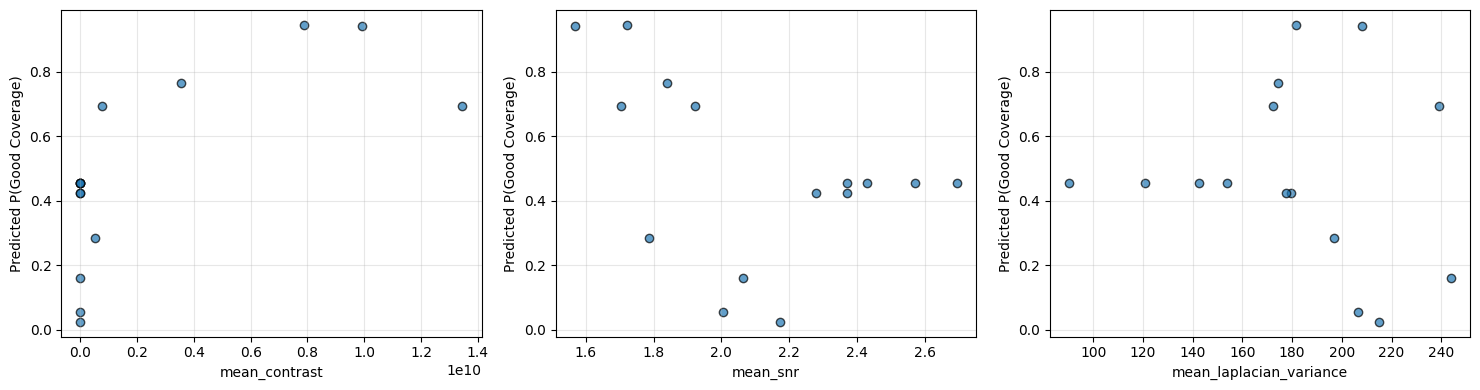

In [41]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ["mean_contrast", "mean_snr", "mean_laplacian_variance"]):
    ax.scatter(remaining_sessions[col], remaining_sessions["predicted_good_lick_coverage"], edgecolor='k', alpha=0.7)
    ax.set_xlabel(col)
    ax.set_ylabel("Predicted P(Good Coverage)")
    ax.grid(True, alpha=0.3)
plt.tight_layout()


In [ ]:
from pathlib import Path
import pandas as pd
import re
from typing import List, Optional, Dict

DATA_ROOT = Path("/root/capsule/data")

# --- 1) find the session folder matching the prefix and containing 'videoprocessed' (or '_processed_') ---

def find_session_folder(session_prefix: str,
                        data_root: Path = DATA_ROOT) -> Optional[Path]:
    """
    Return the most-recently modified directory in data_root whose name:
      - starts with `session_prefix`, and
      - contains either 'videoprocessed' or '_processed_' (robust to naming diffs)
    If none found, return None.
    """
    if not data_root.exists():
        return None

    candidates = []
    for p in data_root.iterdir():
        if not p.is_dir():
            continue
        name = p.name
        if not name.startswith(session_prefix):
            continue
        if ("videoprocessed" in name) or ("_processed_" in name):
            candidates.append(p)

    if not candidates:
        return None

    # Pick the newest by modified time
    candidates.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates[0]


# --- 2) parse a single *.mp4_stats.txt file ---

_VIDEO_STAT_MAP = {
    "Number of sampled frames": "n_sampled_frames",
    "Mean Contrast": "mean_contrast",
    "Mean SNR": "mean_snr",
    "Mean Laplacian Variance": "mean_laplacian_variance",
}

_LINE_RE = re.compile(
    r"^(Number of sampled frames|Mean Contrast|Mean SNR|Mean Laplacian Variance)\s*:\s*([0-9.+-eE]+)\s*$"
)

def parse_video_stats_file(stats_path: Path) -> Dict[str, float]:
    """
    Parse the known metrics from a stats text file.
    Returns a dict with keys from _VIDEO_STAT_MAP values. Missing fields omitted.
    """
    out: Dict[str, float] = {}
    if not stats_path.exists():
        return out
    try:
        with open(stats_path, "r") as f:
            for line in f:
                m = _LINE_RE.match(line.strip())
                if not m:
                    continue
                key_raw, val_str = m.groups()
                key = _VIDEO_STAT_MAP[key_raw]
                if key == "n_sampled_frames":
                    # in case the file writes it as float-like
                    out[key] = int(float(val_str))
                else:
                    out[key] = float(val_str)
    except Exception:
        # Be permissive; just return whatever parsed.
        pass
    return out


# --- 3) collect stats for a list of session prefixes into a tidy DataFrame ---

def get_camera_label_from_filename(filename: str) -> str:
    """
    Infer camera label from file like 'bottom_camera.mp4_stats.txt' -> 'bottom'.
    Falls back to the token right before '.mp4_stats.txt'.
    """
    m = re.search(r"([^/_]+?)(?:_camera)?\.mp4_stats\.txt$", filename)
    if m:
        return m.group(1)
    return filename.replace(".mp4_stats.txt", "")

def collect_video_quality_stats(session_prefixes: List[str],
                                data_root: Path = DATA_ROOT) -> pd.DataFrame:
    """
    For each session prefix:
      - Find matching folder in data_root (see find_session_folder).
      - Look under <folder>/previews/ for *.mp4_stats.txt files.
      - Parse each and return a tidy DataFrame with one row per file.

    Columns:
      session_prefix, matched_folder, camera, stats_path,
      n_sampled_frames, mean_contrast, mean_snr, mean_laplacian_variance
    """
    rows = []

    for sess_pref in session_prefixes:
        folder = find_session_folder(sess_pref, data_root=data_root)
        if folder is None:
            # record a “not found” row so you can see gaps
            rows.append({
                "session_prefix": sess_pref,
                "matched_folder": None,
                "camera": None,
                "stats_path": None,
                "n_sampled_frames": None,
                "mean_contrast": None,
                "mean_snr": None,
                "mean_laplacian_variance": None,
            })
            continue

        previews = folder / "previews"
        stats_files = []
        if previews.exists():
            stats_files.extend(previews.glob("*.mp4_stats.txt"))

        if not stats_files:
            # No stats files present; still record the match so you can debug
            rows.append({
                "session_prefix": sess_pref,
                "matched_folder": str(folder),
                "camera": None,
                "stats_path": None,
                "n_sampled_frames": None,
                "mean_contrast": None,
                "mean_snr": None,
                "mean_laplacian_variance": None,
            })
            continue

        for sp in stats_files:
            parsed = parse_video_stats_file(sp)
            cam = get_camera_label_from_filename(sp.name)
            rows.append({
                "session_prefix": sess_pref,
                "matched_folder": str(folder),
                "camera": cam,
                "stats_path": str(sp),
                "n_sampled_frames": parsed.get("n_sampled_frames"),
                "mean_contrast": parsed.get("mean_contrast"),
                "mean_snr": parsed.get("mean_snr"),
                "mean_laplacian_variance": parsed.get("mean_laplacian_variance"),
            })

    return pd.DataFrame(rows)


In [5]:
from IPython.display import display, Image
import subprocess
from pathlib import Path
import io

def extract_frame_from_bad_clip(session_root):
    """
    Extracts the first frame from the first mp4 in the 'bad' subdirectory of a session analysis folder.
    Returns the frame as a bytes object (PNG).
    """
    bad_dir = Path(session_root) / "example_clips" / "bad"
    mp4_files = sorted(bad_dir.glob("*.mp4"))
    if not mp4_files:
        return None
    mp4_path = mp4_files[0]
    # Use ffmpeg to extract the first frame as PNG to stdout
    cmd = [
        "ffmpeg", "-i", str(mp4_path),
        "-ss", "0.66",
        "-vframes", "1",
        "-f", "image2pipe",
        "-vcodec", "png",
        "-"
    ]
    try:
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        return result.stdout
    except subprocess.CalledProcessError:
        return None

def show_session_bad_frame(session_id, save_root):
    """
    Displays the first frame from the first 'bad' mp4 for a given session_id and save_root.
    """
    session_root = Path(save_root) / session_id
    frame_bytes = extract_frame_from_bad_clip(session_root)
    if frame_bytes:
        display(Image(data=frame_bytes))
    else:
        print(f"No frame found for session {session_id}")

# # Example: show a frame for the first session in summary_df
# show_session_bad_frame(summary_df.iloc[0]["session_id"], save_root)

# # Batch: show frames for all sessions in summary_df
# for session_id in summary_df["session_id"]:
#     print(session_id)
#     show_session_bad_frame(session_id, save_root)

In [6]:
from IPython.display import display
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import io
from PIL import Image as PILImage

def extract_frames_from_bad_clip(session_root, n=10, start_time_s=0.0, interval_ms=20):
    """
    Extracts n frames from the first mp4 in the 'bad' subdirectory, spaced by interval_ms, starting at start_time_s.
    Returns a list of PIL Images.
    """
    bad_dir = Path(session_root) / "example_clips" / "bad"
    mp4_files = sorted(bad_dir.glob("*.mp4"))
    if not mp4_files:
        return []
    mp4_path = mp4_files[0]
    frames = []
    for i in range(n):
        timestamp = start_time_s + (i * interval_ms / 1000.0)
        cmd = [
            "ffmpeg", "-ss", f"{timestamp:.3f}", "-i", str(mp4_path),
            "-vframes", "1",
            "-f", "image2pipe",
            "-vcodec", "png",
            "-"
        ]
        try:
            result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
            img = PILImage.open(io.BytesIO(result.stdout))
            frames.append(img)
        except Exception:
            frames.append(None)
    return frames


In [7]:
def show_session_video_reel(session_id, save_root, n=10, start_time_s=0.0, interval_ms=20, max_per_row=5):
    """
    Displays frames from the first 'bad' mp4 for a given session_id and save_root,
    stacking up to max_per_row frames per row.
    """
    session_root = Path(save_root) / session_id
    frames = extract_frames_from_bad_clip(session_root, n=n, start_time_s=start_time_s, interval_ms=interval_ms)
    n_cols = min(max_per_row, n)
    n_rows = (n + max_per_row - 1) // max_per_row
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten() if n > 1 else [axes]
    for ax, img in zip(axes, frames):
        ax.axis('off')
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
    # Hide any unused axes
    for ax in axes[len(frames):]:
        ax.axis('off')
    plt.tight_layout()
#     plt.show()

# # Example usage: show 12 frames, stacked max 5 per row
# show_session_video_reel(summary_df.iloc[0]["session_id"], save_root, n=20, start_time_s=0.5, interval_ms=20, max_per_row=4)

In [ ]:
# Batch: show frames for all sessions in summary_df
for session_id in summary_df["session_id"]:
    print(session_id)
    show_session_video_reel(session_id, save_root, n=20, start_time_s=0.5, interval_ms=20, max_per_row=4)

In [8]:
def show_session_video_reel(
    session_id, save_root, n=10, start_time_s=0.0, interval_ms=20, max_per_row=5, save_path=None, dpi=300
):
    """
    Displays (and optionally saves) frames from the first 'bad' mp4 for a given session_id and save_root,
    stacking up to max_per_row frames per row.
    """
    session_root = Path(save_root) / session_id
    frames = extract_frames_from_bad_clip(session_root, n=n, start_time_s=start_time_s, interval_ms=interval_ms)
    n_cols = min(max_per_row, n)
    n_rows = (n + max_per_row - 1) // max_per_row
    # Try to infer frame size for better aspect ratio (optional)
    frame_width, frame_height = (frames[0].width, frames[0].height) if frames and frames[0] else (3*100, 3*100)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * frame_width / 100, n_rows * frame_height / 100))
    axes = axes.flatten() if n > 1 else [axes]
    for ax, img in zip(axes, frames):
        ax.axis('off')
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
    for ax in axes[len(frames):]:
        ax.axis('off')
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', dpi=dpi)
        plt.close(fig)
    else:
        plt.show()

# for session_id in summary_df["session_id"]:
#     session_root = Path(save_root) / session_id
#     bad_dir = session_root / "example_clips" / "bad"
#     bad_dir.mkdir(parents=True, exist_ok=True)
#     save_path = bad_dir / "video_reel.png"
#     show_session_video_reel(
#         session_id, save_root,
#         n=20, start_time_s=0.5, interval_ms=20,
#         max_per_row=5, save_path=save_path
#     )

In [28]:
# Example usage
save_root_ood = "/root/capsule/scratch/session_analysis_out_of_distribution"
summary_df_ood = load_summary_results(save_root_ood)


for session_id in summary_df_ood["session_id"]:
    session_root = Path(save_root_ood) / session_id
    bad_dir = session_root / "example_clips" / "bad"
    bad_dir.mkdir(parents=True, exist_ok=True)
    save_path = bad_dir / "video_reel.png"
    show_session_video_reel(
        session_id, save_root_ood,
        n=20, start_time_s=0.5, interval_ms=20,
        max_per_row=5, save_path=save_path
    )

In [ ]:

# Example usage
save_root_id = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root_id)

for session_id in summary_df_id["session_id"]:
    session_root = Path(save_root_id) / session_id
    bad_dir = session_root / "example_clips" / "bad"
    bad_dir.mkdir(parents=True, exist_ok=True)
    save_path = bad_dir / "video_reel.png"
    show_session_video_reel(
        session_id, save_root_id,
        n=20, start_time_s=0.5, interval_ms=20,
        max_per_row=5, save_path=save_path
    )


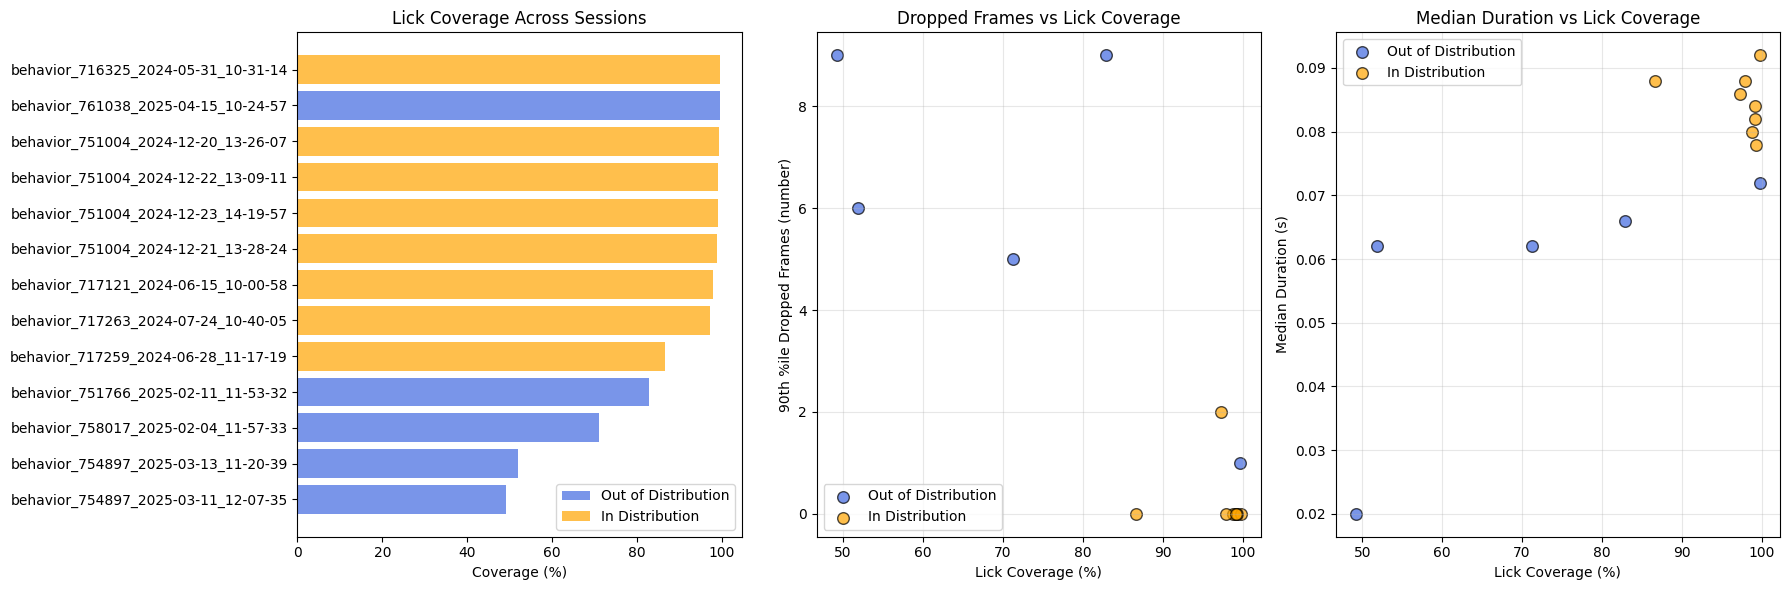

In [7]:
save_root_ood = "/root/capsule/scratch/session_analysis_out_of_distribution"
summary_df_ood = load_summary_results(save_root_ood)

save_root_id = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root_id)

plot_combined_summary_compare(summary_df_ood, summary_df_id)